# Steven Villalon: Portfolio Project 1
### Fall 2024

I have always been a big fan of the NBA, especially my hometown Miami Heat. As I work through my first semester in the Data Science master's program at Notre Dame, I wanted to do a simple project that would allow me to apply some of the lessons and techniques that I have been learning this semester.

Most of us who watch sports like to debate silly things like, "How likely is it that Lebron will go off for 40 points tonight?" For the project below, I will practice making histograms in Python and use them to assess the liklihood that a player will reach a certain threshold for a given statistic. I will be using data from the most recently completed NBA season (plus the handful of games that have already taken place this season) to try to answer some fun questions about my favorite players.

Eventually, I would like to turn this to an interactive online dashboard.

The data is provided by the NBA using [nba_api](https://github.com/swar/nba_api/tree/master).

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from scipy import stats
from datetime import datetime

I will focus my analysis on my favorite team, the 3-time NBA champion Miami Heat. However, I have set up the notebook so that anyone playing with it could easily select another team.

In [2]:
# Team of Interest
my_team_name = "Miami Heat"

In [3]:
# Step 1: Get Team ID
from nba_api.stats.static import teams
from nba_api.stats.endpoints import commonteamroster

nba_teams = teams.get_teams()
my_team_info = [team for team in nba_teams if team['full_name'] == my_team_name]
my_team_id = my_team_info[0]["id"]
print(f"The team ID for the {my_team_name} is {my_team_id}.")

# Get Team Logo
url = f"https://cdn.nba.com/logos/nba/{my_team_id}/primary/L/logo.svg"

# Display the image
display(Image(url=url))

The team ID for the Miami Heat is 1610612748.


In [4]:
# Step 2: Retrieve current roster for Team of Interest
roster = commonteamroster.CommonTeamRoster(team_id=my_team_id)
my_team_roster = roster.get_data_frames()[0]
my_team_roster.head()


,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED
0,1610612748,2024,00,Josh Richardson,Josh,josh-richardson,0,G,6-5,200,"SEP 15, 1993",31.0,9,Tennessee,1626196,Signed on 07/02/23
1,1610612748,2024,00,Terry Rozier,Terry,terry-rozier,2,G,6-1,190,"MAR 17, 1994",30.0,9,Louisville,1626179,Traded from CHA on 01/23/24
2,1610612748,2024,00,Nikola Jović,Nikola,nikola-jović,5,F,6-10,205,"JUN 09, 2003",21.0,2,Mega Basket,1631107,#27 Pick in 2022 Draft
3,1610612748,2024,00,Kel'el Ware,Kel'el,kelel-ware,7,C,7-0,230,"APR 20, 2004",20.0,R,Indiana,1642276,#15 Pick in 2024 Draft
4,1610612748,2024,00,Josh Christopher,Josh,josh-christopher,8,G,6-4,215,"DEC 08, 2001",22.0,2,Arizona State,1630528,Signed on 07/25/24


In [5]:
# Aside: Retrieve coaches for Team of Interest
my_team_coaches = roster.get_data_frames()[1]
my_team_coaches.head()

,TEAM_ID,SEASON,COACH_ID,FIRST_NAME,LAST_NAME,COACH_NAME,IS_ASSISTANT,COACH_TYPE,SORT_SEQUENCE,SUB_SORT_SEQUENCE
0,1610612748,2024,1787,Erik,Spoelstra,Erik Spoelstra,1,Head Coach,None,1
1,1610612748,2024,2406,Caron,Butler,Caron Butler,2,Assistant Coach,None,5
2,1610612748,2024,204226,Chris,Quinn,Chris Quinn,2,Assistant Coach,None,5
3,1610612748,2024,204229,Malik,Allen,Malik Allen,2,Assistant Coach,None,5
4,1610612748,2024,1629855,Eric,Glass,Eric Glass,2,Assistant Coach,None,5


In [6]:
# Step 3: Get Game Logs for Dates of Interest
from nba_api.stats.endpoints import playergamelog

# Today's Date for Date Range Below
todays_date = datetime.today().date()
todays_date = todays_date.strftime('%Y-%m-%d')

# Get Player IDs for Team of Interest
player_ids = list(my_team_roster["PLAYER_ID"])

# Relevant Dates
start_date = '2023-10-24' #start of 2023-2024 season
end_date = todays_date #today

# Create empty list to collect game logs for all players
all_game_logs = []

# Loop through each player ID to fetch their game logs
for player_id in player_ids:
    # Pull game logs for the 2023-24 season
    game_log_23_24 = playergamelog.PlayerGameLog(player_id=player_id, season='2023-24', season_type_all_star='Regular Season')
    game_log_df_23_24 = game_log_23_24.get_data_frames()[0]

    # Pull game logs for the 2024-25 season
    game_log_24_25 = playergamelog.PlayerGameLog(player_id=player_id, season='2024-25', season_type_all_star='Regular Season')
    game_log_df_24_25 = game_log_24_25.get_data_frames()[0]

    # Combine both seasons’ data
    combined_game_logs = pd.concat([game_log_df_23_24, game_log_df_24_25])

    # Filter for the desired date range
    combined_game_logs['GAME_DATE'] = pd.to_datetime(combined_game_logs['GAME_DATE'], format='%b %d, %Y')
    filtered_game_logs = combined_game_logs[(combined_game_logs['GAME_DATE'] >= start_date) & 
                                            (combined_game_logs['GAME_DATE'] <= end_date)]
    
    # Add player ID for reference
    filtered_game_logs['PLAYER_ID'] = player_id
    
    # Append filtered logs to the list
    all_game_logs.append(filtered_game_logs)

# Combine all players' game logs into a single DataFrame
all_game_logs_df = pd.concat(all_game_logs, ignore_index=True)

# Add player names
clean_game_logs = pd.merge(all_game_logs_df, my_team_roster[["PLAYER_ID", "PLAYER"]], on="PLAYER_ID", how='left')
clean_game_logs.head()

/var/folders/ts/08ksnqhx0bz0sjbnl885d0gm0000gn/T/ipykernel_37196/2271843702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_game_logs = pd.concat([game_log_df_23_24, game_log_df_24_25])
/var/folders/ts/08ksnqhx0bz0sjbnl885d0gm0000gn/T/ipykernel_37196/2271843702.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_game_logs = pd.concat([game_log_df_23_24, game_log_df_24_25])
/var/folders/ts/08ksnqhx0bz0sjbnl885d0gm0000gn/T/ipykernel_37196/2271843702.py:43: FutureWarning: Th

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,PLAYER_ID,PLAYER
0,22023,1626196,0022300759,2024-02-11,MIA vs. BOS,L,7,1,3,0.333,...,2,0,0,0,0,2,-6,1,1626196,Josh Richardson
1,22023,1626196,0022300730,2024-02-07,MIA vs. SAS,W,26,2,6,0.333,...,0,0,0,0,2,9,-3,1,1626196,Josh Richardson
2,22023,1626196,0022300721,2024-02-06,MIA vs. ORL,W,27,5,7,0.714,...,1,2,0,0,4,13,16,1,1626196,Josh Richardson
3,22023,1626196,0022300708,2024-02-04,MIA vs. LAC,L,33,6,13,0.462,...,4,0,0,0,2,14,-8,1,1626196,Josh Richardson
4,22023,1626196,0022300689,2024-02-02,MIA @ WAS,W,25,3,8,0.375,...,2,0,0,1,2,7,-6,1,1626196,Josh Richardson


At this point, I have a dataframe with some basic box score stats for each player on my team of interest. The games go back to the start of the NBA season that began October 2023 and run through today.

The dataset includes players on the team of interest *today*, but the stats may be from while that player was on another team. For example, Alec Burks did not play for the Heat last season, so the 60+ games below are from games he played for the Pistons and Knicks.

There will only be a game log if the player entered the game. There may be instances where the player was injured and completely unavailable, or the player was available but the coach chose not to sub him in.

In [7]:
# Count Games per Player
games_by_player = clean_game_logs.groupby('PLAYER').size()
games_by_player

PLAYER
Alec Burks           71
Bam Adebayo          80
Dru Smith            13
Duncan Robinson      76
Haywood Highsmith    73
Jaime Jaquez Jr.     81
Jimmy Butler         68
Josh Richardson      47
Kel'el Ware           5
Kevin Love           56
Nikola Jović         55
Pelle Larsson         6
Terry Rozier         70
Thomas Bryant        45
Tyler Herro          51
dtype: int64

Some observations from the counts above:
1. Heat players miss a lot of games due to injury, especially stars Jimmy Butler and Tyler Herro
2. Rookies: Kel'el Ware, Keshad Johnson, Pelle Larsson
3. Two-way players: Josh Christopher (2 yrs), Keshad Johnson (R), Dru Smith (2 yrs)
4. Key Injuries:
    - Josh Richardson had shoulder surgery in the spring
    - Dru Smith tore his ACL early last season
5. Alec Burks is a veteran who played for DET/NYK last season, so most of his stats are not in Heat uniform

# Histograms of Key Stats for a Player of Interest

In [8]:
# List of Players on Team of Interest
my_team_roster["PLAYER"]

0       Josh Richardson
1          Terry Rozier
2          Nikola Jović
3           Kel'el Ware
4      Josh Christopher
5         Pelle Larsson
6      Jaime Jaquez Jr.
7             Dru Smith
8           Bam Adebayo
9           Tyler Herro
10       Keshad Johnson
11           Alec Burks
12         Jimmy Butler
13    Haywood Highsmith
14        Thomas Bryant
15           Kevin Love
16      Duncan Robinson
Name: PLAYER, dtype: object

In [9]:
# Step 4: Select Player of Interest
player_of_interest = "Jimmy Butler"

# Filter the Game Logs to the Player of Interest
player_of_interest_id = my_team_roster.loc[my_team_roster["PLAYER"] == player_of_interest, "PLAYER_ID"].values[0]
player_of_interest_data = clean_game_logs.loc[clean_game_logs["PLAYER"] == player_of_interest]
n_games = games_by_player[player_of_interest]

# Get Image of Player of Interest
url = f"https://cdn.nba.com/headshots/nba/latest/1040x760/{player_of_interest_id}.png"

# Display the image
display(Image(url=url))

## POINTS

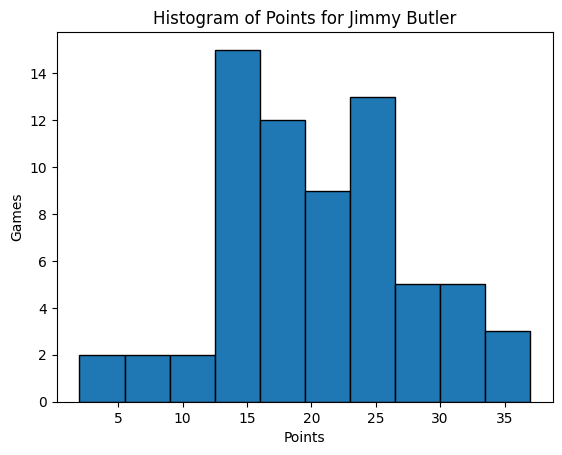

Jimmy Butler has averaged 20.2 points per game over his past 68 regular season games.
Median points per game = 20.0
Minimum points per game = 2
Maximum points per game = 37
Standard deviation of points per game = 7.3


In [10]:
# PLOT 1: POINTS histogram

# Create plot
plt.hist(player_of_interest_data["PTS"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Points')
plt.ylabel('Games')
plt.title(f"Histogram of Points for {player_of_interest}")

# Show the plot
plt.show()

# Get key stats
mean_pts = round(np.mean(player_of_interest_data["PTS"]),1)
median_pts = round(np.median(player_of_interest_data["PTS"]),1)
min_pts = np.min(player_of_interest_data["PTS"])
max_pts = np.max(player_of_interest_data["PTS"])
sd_pts = round(np.std(player_of_interest_data["PTS"]),1)

# Print key stats
print(f"{player_of_interest} has averaged {mean_pts} points per game over his past {n_games} regular season games.")
print(f"Median points per game = {median_pts}")
print(f"Minimum points per game = {min_pts}")
print(f"Maximum points per game = {max_pts}")
print(f"Standard deviation of points per game = {sd_pts}")

In [11]:
# Sort the data for cumulative distribution
sorted_pts_data = player_of_interest_data.sort_values(by="PTS")

# Define the value of interest
x_pts = 30

# Calculate the cumulative probability for x
ecdf = round(100 - stats.percentileofscore(sorted_pts_data["PTS"], x_pts, kind='strict'),2)
print(f"The likelihood of {player_of_interest} getting {x_pts} points or more is approximately {ecdf}%.")

The likelihood of Jimmy Butler getting 30 points or more is approximately 11.76%.


## REBOUNDS

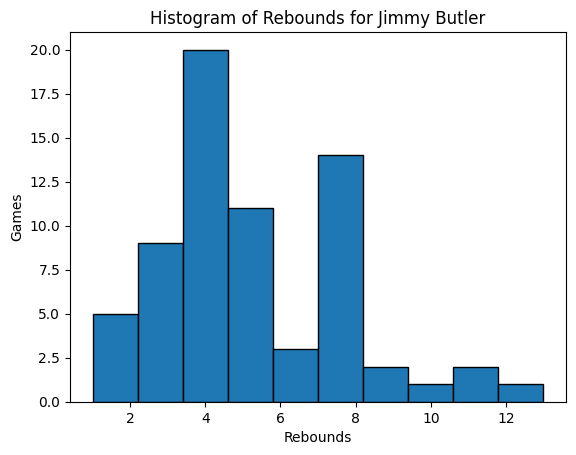

Jimmy Butler has averaged 5.2 rebounds per game over his past 68 regular season games.
Median rebounds per game = 4.5
Minimum rebounds per game = 1
Maximum rebounds per game = 13
Standard deviation of rebounds per game = 2.4


In [12]:
# PLOT 2: REBOUNDS histogram

# Create plot
plt.hist(player_of_interest_data["REB"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Rebounds')
plt.ylabel('Games')
plt.title(f"Histogram of Rebounds for {player_of_interest}")

# Show the plot
plt.show()

# Get key stats
mean_reb = round(np.mean(player_of_interest_data["REB"]),1)
median_reb = round(np.median(player_of_interest_data["REB"]),1)
min_reb = np.min(player_of_interest_data["REB"])
max_reb = np.max(player_of_interest_data["REB"])
sd_reb = round(np.std(player_of_interest_data["REB"]),1)

# Print key stats
print(f"{player_of_interest} has averaged {mean_reb} rebounds per game over his past {n_games} regular season games.")
print(f"Median rebounds per game = {median_reb}")
print(f"Minimum rebounds per game = {min_reb}")
print(f"Maximum rebounds per game = {max_reb}")
print(f"Standard deviation of rebounds per game = {sd_reb}")

In [13]:
# Sort the data for cumulative distribution
sorted_pts_data = player_of_interest_data.sort_values(by="REB")

# Define the value of interest
x_reb = 8

# Calculate the cumulative probability for x
ecdf = round(100 - stats.percentileofscore(sorted_pts_data["REB"], x_reb, kind='strict'),2)
print(f"The likelihood of {player_of_interest} getting {x_reb} rebounds or more is approximately {ecdf}%.")

The likelihood of Jimmy Butler getting 8 rebounds or more is approximately 17.65%.


## ASSISTS

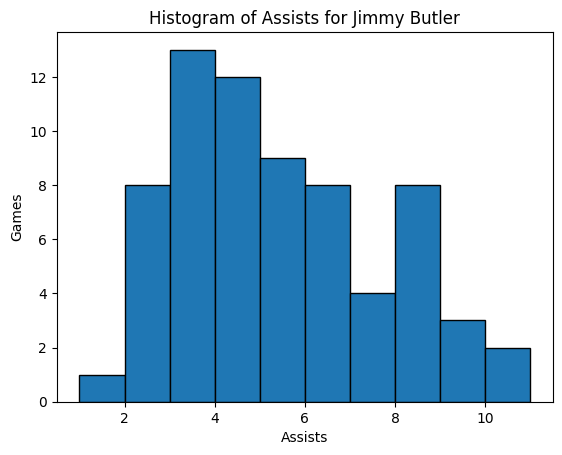

Jimmy Butler has averaged 5.0 assists per game over his past 68 regular season games.
Median assists per game = 4.5
Minimum assists per game = 1
Maximum assists per game = 11
Standard deviation of assists per game = 2.3


In [14]:
# PLOT 3: ASSISTS histogram

# Create plot
plt.hist(player_of_interest_data["AST"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Assists')
plt.ylabel('Games')
plt.title(f"Histogram of Assists for {player_of_interest}")

# Show the plot
plt.show()

# Get key stats
mean_ast = round(np.mean(player_of_interest_data["AST"]),1)
median_ast = round(np.median(player_of_interest_data["AST"]),1)
min_ast = np.min(player_of_interest_data["AST"])
max_ast = np.max(player_of_interest_data["AST"])
sd_ast = round(np.std(player_of_interest_data["AST"]),1)

# Print key stats
print(f"{player_of_interest} has averaged {mean_ast} assists per game over his past {n_games} regular season games.")
print(f"Median assists per game = {median_ast}")
print(f"Minimum assists per game = {min_ast}")
print(f"Maximum assists per game = {max_ast}")
print(f"Standard deviation of assists per game = {sd_ast}")

In [15]:
# Sort the data for cumulative distribution
sorted_pts_data = player_of_interest_data.sort_values(by="AST")

# Define the value of interest
x_ast = 7

# Calculate the cumulative probability for x
ecdf = round(100 - stats.percentileofscore(sorted_pts_data["AST"], x_ast, kind='strict'),2)
print(f"The likelihood of {player_of_interest} getting {x_ast} assists or more is approximately {ecdf}%.")

The likelihood of Jimmy Butler getting 7 assists or more is approximately 25.0%.


## 3-POINTERS

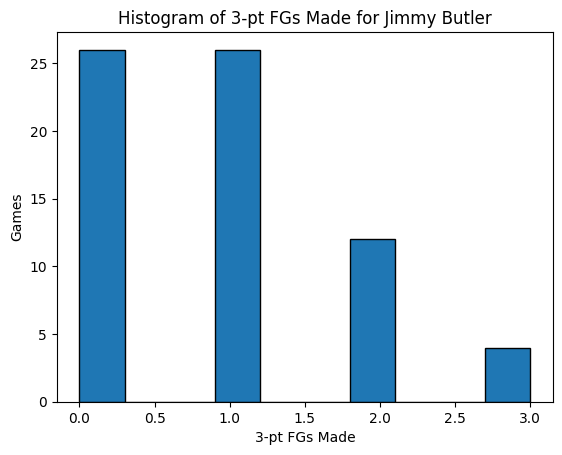

Jimmy Butler has averaged 0.9 3-pointers per game over his past 68 regular season games.
Median 3-pointers per game = 1.0
Minimum 3-pointers per game = 0
Maximum 3-pointers per game = 3
Standard deviation of 3-pointers per game = 0.9


In [16]:
# PLOT 4: 3-POINTERS histogram

# Create plot
plt.hist(player_of_interest_data["FG3M"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('3-pt FGs Made')
plt.ylabel('Games')
plt.title(f"Histogram of 3-pt FGs Made for {player_of_interest}")

# Show the plot
plt.show()

# Get key stats
mean_fg3m = round(np.mean(player_of_interest_data["FG3M"]),1)
median_fg3m = round(np.median(player_of_interest_data["FG3M"]),1)
min_fg3m = np.min(player_of_interest_data["FG3M"])
max_fg3m = np.max(player_of_interest_data["FG3M"])
sd_fg3m = round(np.std(player_of_interest_data["FG3M"]),1)

# Print key stats
print(f"{player_of_interest} has averaged {mean_fg3m} 3-pointers per game over his past {n_games} regular season games.")
print(f"Median 3-pointers per game = {median_fg3m}")
print(f"Minimum 3-pointers per game = {min_fg3m}")
print(f"Maximum 3-pointers per game = {max_fg3m}")
print(f"Standard deviation of 3-pointers per game = {sd_fg3m}")

In [17]:
# Sort the data for cumulative distribution
sorted_pts_data = player_of_interest_data.sort_values(by="FG3M")

# Define the value of interest
x_fg3m = 2

# Calculate the cumulative probability for x
ecdf = round(100 - stats.percentileofscore(sorted_pts_data["FG3M"], x_fg3m, kind='strict'),2)
print(f"The likelihood of {player_of_interest} getting {x_fg3m} 3-pointers or more is approximately {ecdf}%.")

The likelihood of Jimmy Butler getting 2 3-pointers or more is approximately 23.53%.


## FREE THROWS

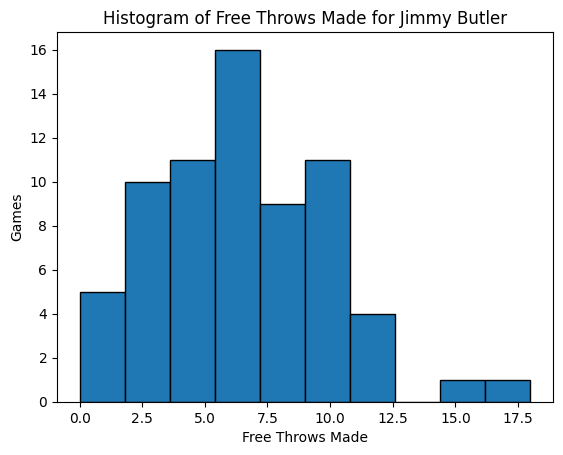

Jimmy Butler has averaged 6.4 free throws made per game over his past 68 regular season games.
Median free throws made per game = 6.0
Minimum free throws made per game = 0
Maximum free throws made per game = 18
Standard deviation of free throws made per game = 3.4


In [18]:
# PLOT 5: FREE THROWS histogram

# Create plot
plt.hist(player_of_interest_data["FTM"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Free Throws Made')
plt.ylabel('Games')
plt.title(f"Histogram of Free Throws Made for {player_of_interest}")

# Show the plot
plt.show()

# Get key stats
mean_ftm = round(np.mean(player_of_interest_data["FTM"]),1)
median_ftm = round(np.median(player_of_interest_data["FTM"]),1)
min_ftm = np.min(player_of_interest_data["FTM"])
max_ftm = np.max(player_of_interest_data["FTM"])
sd_ftm = round(np.std(player_of_interest_data["FTM"]),1)

# Print key stats
print(f"{player_of_interest} has averaged {mean_ftm} free throws made per game over his past {n_games} regular season games.")
print(f"Median free throws made per game = {median_ftm}")
print(f"Minimum free throws made per game = {min_ftm}")
print(f"Maximum free throws made per game = {max_ftm}")
print(f"Standard deviation of free throws made per game = {sd_ftm}")

In [19]:
# Sort the data for cumulative distribution
sorted_pts_data = player_of_interest_data.sort_values(by="FTM")

# Define the value of interest
x_ftm = 2

# Calculate the cumulative probability for x
ecdf = round(100 - stats.percentileofscore(sorted_pts_data["FTM"], x_ftm, kind='strict'),2)
print(f"The likelihood of {player_of_interest} making {x_ftm} free throws or more is approximately {ecdf}%.")

The likelihood of Jimmy Butler making 2 free throws or more is approximately 92.65%.


## STEALS

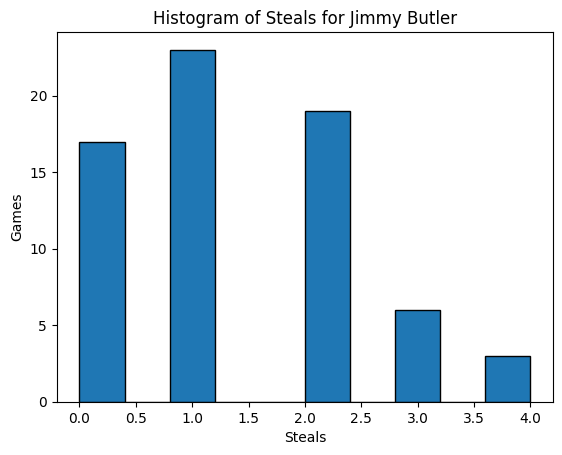

Jimmy Butler has averaged 1.3 steals per game over his past 68 regular season games.
Median steals per game = 1.0
Minimum steals per game = 0
Maximum steals per game = 4
Standard deviation of steals per game = 1.1


In [20]:
# PLOT 6: STEALS histogram

# Create plot
plt.hist(player_of_interest_data["STL"], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Steals')
plt.ylabel('Games')
plt.title(f"Histogram of Steals for {player_of_interest}")

# Show the plot
plt.show()

# Get key stats
mean_stl = round(np.mean(player_of_interest_data["STL"]),1)
median_stl = round(np.median(player_of_interest_data["STL"]),1)
min_stl = np.min(player_of_interest_data["STL"])
max_stl = np.max(player_of_interest_data["STL"])
sd_stl = round(np.std(player_of_interest_data["STL"]),1)

# Print key stats
print(f"{player_of_interest} has averaged {mean_stl} steals per game over his past {n_games} regular season games.")
print(f"Median steals per game = {median_stl}")
print(f"Minimum steals per game = {min_stl}")
print(f"Maximum steals per game = {max_stl}")
print(f"Standard deviation of steals per game = {sd_stl}")

In [21]:
# Sort the data for cumulative distribution
sorted_pts_data = player_of_interest_data.sort_values(by="STL")

# Define the value of interest
x_stl = 2

# Calculate the cumulative probability for x
ecdf = round(100 - stats.percentileofscore(sorted_pts_data["STL"], x_stl, kind='strict'),2)
print(f"The likelihood of {player_of_interest} getting {x_stl} steals or more is approximately {ecdf}%.")

The likelihood of Jimmy Butler getting 2 steals or more is approximately 41.18%.
